In [400]:
import sympy as sym
import numpy as np
from sympy import symbols, Eq
from sympy.abc import alpha, beta, theta, sigma, rho, phi, mu, nu, kappa
import matplotlib.pyplot as plt

# Sims 1999

$$\Gamma_0 y_t=\Gamma_1 y_{t-1}+C+\Psi z_t+\Pi\eta_t$$

In [401]:
def gensys(Gamma0:sym.Matrix, Gamma1:sym.Matrix, 
                 C:sym.Matrix=None, Psi:sym.Matrix=None, 
                 Eta:sym.Matrix=None,
                 out:str = 'np.array')->tuple:
    return_Theta_c = True
    if C is None:
        C, return_Theta_c = sym.zeros(Gamma0.rows,1), False
    if Eta is None:
        Eta = sym.zeros(Gamma0.rows,1)
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    P=P.permute_cols(ind)  
    #P*Lambda*P.inv()=Gamma1 check 
    P_inv = P.inv()
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])>1])
    n_u = Lambda.rows-n_s
    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]*Lambda_S*P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]*P_inv[:n_s,:]+P[:,n_s:]*(sym.eye(n_u)-Lambda_U)*P_inv[n_s:,:])*C
    Phi = P_inv[:n_s,:]*Eta*(P_inv[n_s:,:]*Eta).inv()
    Theta_z = (P[:,:n_s]*P_inv[:n_s,:]-P[:,:n_s]*Phi*P_inv[n_s:,:])*Psi
    Theta_1 = Theta_1.as_real_imag()[0]
    Theta_c = Theta_c.as_real_imag()[0]
    Theta_z = Theta_z.as_real_imag()[0]
    if out=='np.array':
        Theta_1 = np.array(Theta_1).astype(np.float64)
        Theta_c = np.array(Theta_c).astype(np.float64)
        Theta_z = np.array(Theta_z).astype(np.float64) 
    if return_Theta_c:
        return Theta_1, Theta_c, Theta_z
    else:
        return Theta_1, Theta_z

In [402]:
def gensys(Gamma0:sym.Matrix, Gamma1:sym.Matrix, 
                 C:sym.Matrix=None, Psi:sym.Matrix=None, 
                 Eta:sym.Matrix=None,
                 out:str = 'np.array')->tuple:
    return_Theta_c = True
    if C is None:
        C, return_Theta_c = sym.zeros(Gamma0.rows,1), False
    if Eta is None:
        Eta = sym.zeros(Gamma0.rows,1)
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])>1])
    n_u = Lambda.rows-n_s
    
    P=P.permute_cols(ind)  
    P = np.array(P).astype(np.complex128) 
    P_inv = np.linalg.inv(P)

    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]@Lambda_S@P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]@P_inv[:n_s,:]+P[:,n_s:]@(sym.eye(n_u)-Lambda_U)@P_inv[n_s:,:])@C
    Phi = P_inv[:n_s,:]@Eta@(P_inv[n_s:,:]@Eta).inv()
    Theta_z = (P[:,:n_s]@P_inv[:n_s,:]-P[:,:n_s]@Phi@P_inv[n_s:,:])@Psi
    Theta_1 = np.real(np.array(Theta_1).astype(np.complex64))
    Theta_c = np.real(np.array(Theta_c).astype(np.complex64))
    Theta_z = np.real(np.array(Theta_z).astype(np.complex64)) 
    #Theta_1 = Theta_1.as_real_imag()[0]
    #Theta_c = Theta_c.as_real_imag()[0]
    #Theta_z = Theta_z.as_real_imag()[0]
    #if out=='np.array':
    #    Theta_1 = np.array(Theta_1).astype(np.float64)
    #    Theta_c = np.array(Theta_c).astype(np.float64)
    #    Theta_z = np.array(Theta_z).astype(np.float64) 
    if return_Theta_c:
        return Theta_1, Theta_c, Theta_z
    else:
        return Theta_1, Theta_z

## Galí Sticky Prices

In [403]:
E_y, E_pi, y_, pi_ = symbols('E_{t-1}y_t,E_{t-1}\pi^p_t, y_{t-1}, \pi_{t-1}')
Ey1, Epi1, y, pi = symbols('E_ty_{t+1},E_t\pi^p_{t+1}, y_t, \pi_t')
phi_y, phi_p =symbols('\phi_y, \phi_p')
lam = symbols('\lambda')
eta_y, eta_pi = symbols('\eta_y, \eta_{\pi}')
v = symbols('v')

In [404]:
i = rho+phi_p*pi+phi_y*y+v

In [405]:
is_curve = Eq(y, Ey1-1/sigma*(i-Epi1-rho))
nkpc = Eq(pi, beta*Epi1+kappa*y)
exp_y = Eq(y, E_y+eta_y)
exp_pi = Eq(pi, E_pi+eta_pi)

In [406]:
var  = Ey1, Epi1, y, pi
var_ = E_y, E_pi, y_, pi_
z = v,
eta = eta_y, eta_pi

In [407]:
Gamma0,_ = sym.linear_eq_to_matrix([is_curve,nkpc, exp_y, exp_pi], var)
Gamma1,_ = sym.linear_eq_to_matrix(_,var_)
Psi, _ = sym.linear_eq_to_matrix(_, z)
Eta, C = sym.linear_eq_to_matrix(_, eta)
Psi = -Psi

In [408]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps':9,
             '\phi_p':1.5, '\phi_y':0.5/4,
             'sigma':1,
              'theta':3/4}
calibration['Theta']=(1-calibration['alpha'])/(1-calibration['alpha']+calibration['alpha']*calibration['eps'])
calibration['lambda']=(1-calibration['theta'])*(1-calibration['beta']*calibration['theta'])/calibration['theta']*calibration['Theta']
calibration['kappa']=calibration['lambda']*(calibration['sigma']+(calibration['phi']+calibration['alpha'])/(1-calibration['alpha']))

In [409]:
Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
Psi = Psi.subs(calibration)

In [410]:
Theta_1, Theta_z = gensys(Gamma0=Gamma0, Gamma1=Gamma1, Psi=Psi, Eta=Eta)

In [411]:
T=15
z_t = np.zeros((T,len(z)))
y_t = np.zeros((T,len(var)))
y_ = np.array([0,0,0,0])
rho_v = 0.5
t=np.arange(0,T)
v= 0.25*np.exp(-rho_v*t)
y_t[0] = y_
z_t[:,0] = v

In [412]:
Psi

Matrix([
[-1],
[ 0],
[ 0],
[ 0]])

In [413]:
Theta_z

array([[-0.        ],
       [ 0.        ],
       [-0.7233273 ],
       [-0.12417119]], dtype=float32)

In [414]:
for i in range(1,T):
    y_t[i]=(Theta_1@y_t[[i-1]].T+Theta_z@z_t[[i]].T).flatten()

C:\Users\MBBar\AppData\Local\Temp/ipykernel_29052/2350625629.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


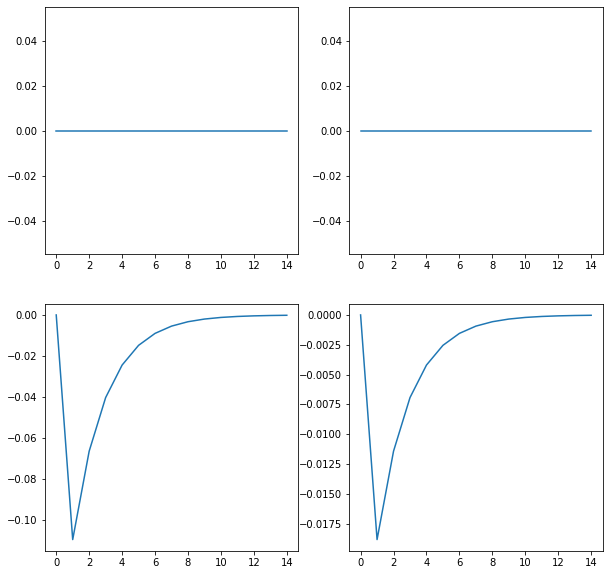

In [415]:
fig,ax=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
ax[0,0].plot(t,y_t[:,0])
ax[0,1].plot(t,y_t[:,1])
ax[1,0].plot(t,y_t[:,2])
ax[1,1].plot(t,y_t[:,3])
fig.show()

In [ ]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps_p':9,
             '\phi_p':1.5,'\phi_w':0.125, '\phi_y':0.5/4,
             'eps_w':4.5, 'sigma':1,
              'theta_p':3/4,'theta_w':3/4}

In [ ]:
class StickyWageNK():
    def __init__(self):
        self.calibration = None
    def calibrate(self, calibration: dict):
        theta_w = calibration['theta_w']
        theta_p = calibration['theta_p']
        beta = calibration['beta']
        phi = calibration['phi']
        eps_w = calibration['eps_w']
        eps_p = calibration['eps_w']
        alpha = calibration['alpha']
        sigma = calibration['sigma']
        calibration['\lambda_w']=(1-theta_w)*(1-beta*theta_w)/(theta_w*(1+eps_w*phi))
        calibration['\lambda_p']=(1-theta_p)*(1-beta*theta_p)/(theta_p)*(1-alpha)/(1-alpha+alpha*eps_p)
        calibration['chi_p'] = alpha*calibration['\lambda_p']/(1-alpha)
        calibration['chi_w'] = calibration['\lambda_w']*(sigma+phi/(1-alpha))
        self.calibration = calibration

In [ ]:
economy=StickyWageNK()
economy.calibrate(calibration)

In [ ]:
calibration = economy.calibration

In [ ]:
Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
C = C.subs(calibration)
Psi = Psi.subs(calibration)

In [ ]:
Theta_1, Theta_c, Theta_z = solve_system(Gamma0, Gamma1, C, Psi, Eta)

**Solve Impulse Response**

## Galí Sticky wages and sticky prices

In [2]:
y,pi_p, pi_w, w_ = symbols('y_t,\pi^p_t,\pi_t^w,\omega_{t-1}')
y1,pi_p1, pi_w1, w = symbols('E_ty_{t+1},E_t\pi^p_{t+1},E_t\pi_{t+1}^w,\omega_t')

phi_y, phi_p, phi_w=symbols('\phi_y, \phi_p, \phi_w')
lam_p, lam_w = symbols('\lambda_p, \lambda_w')
chi_p, chi_w = symbols('chi_p, chi_w')

v, Delta_w = symbols('v, \Delta\omega_t^n')

In [3]:
i = rho+phi_p*pi_p+phi_w*pi_w+phi_y*y+v

In [4]:
is_curve = Eq(y, y1-1/sigma*(i-pi_p1-rho))
real_wage = Eq(w, w_+pi_w-pi_p-Delta_w)
price_nkpc = Eq(pi_w, beta*pi_w1+chi_w*y-lam_w*w)
wage_nkpc = Eq(pi_p, beta*pi_p1+chi_p*y+lam_p*w)

In [5]:
var  = y1,pi_p1, pi_w1, w
var_ = y,pi_p, pi_w, w_
z = v, Delta_w

In [6]:
Gamma0,_ = sym.linear_eq_to_matrix([is_curve,real_wage,price_nkpc,wage_nkpc], var)
Gamma1,_ = sym.linear_eq_to_matrix(_,var_)
Psi, C = sym.linear_eq_to_matrix(_, z)
Eta = sym.Matrix([[1,0,0,0],[0,0,1,0],[0,0,0,1]]).T

In [7]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps_p':9,
             '\phi_p':1.5,'\phi_w':0.125, '\phi_y':0.5/4,
             'eps_w':4.5, 'sigma':1,
              'theta_p':3/4,'theta_w':3/4}

In [8]:
class StickyWageNK():
    def __init__(self):
        self.calibration = None
    def calibrate(self, calibration: dict):
        theta_w = calibration['theta_w']
        theta_p = calibration['theta_p']
        beta = calibration['beta']
        phi = calibration['phi']
        eps_w = calibration['eps_w']
        eps_p = calibration['eps_w']
        alpha = calibration['alpha']
        sigma = calibration['sigma']
        calibration['\lambda_w']=(1-theta_w)*(1-beta*theta_w)/(theta_w*(1+eps_w*phi))
        calibration['\lambda_p']=(1-theta_p)*(1-beta*theta_p)/(theta_p)*(1-alpha)/(1-alpha+alpha*eps_p)
        calibration['chi_p'] = alpha*calibration['\lambda_p']/(1-alpha)
        calibration['chi_w'] = calibration['\lambda_w']*(sigma+phi/(1-alpha))
        self.calibration = calibration

In [9]:
economy=StickyWageNK()
economy.calibrate(calibration)

In [10]:
calibration = economy.calibration

In [11]:
Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
C = C.subs(calibration)
Psi = Psi.subs(calibration)

In [12]:
def solve_system(Gamma0:sym.Matrix, Gamma1:sym.Matrix, C:sym.Matrix, Psi:sym.Matrix, Eta:sym.Matrix,
                 out:str = 'np.array')->tuple:
    if np.abs(Gamma0.det())<1e-10:
        raise ValueError('Gamma0 is not invertible')
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    P=P.permute_cols(ind)
    P_inv = P.inv()
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
    n_u = Lambda.rows-n_s
    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]*Lambda_S*P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]*P_inv[:n_s,:]+P[:,n_s:]*(sym.eye(n_u)-Lambda_U)*P_inv[n_s:,:])*C
    Phi = P_inv[:n_s,:]*Eta*(P_inv[n_s:,:]*Eta).inv()
    Theta_z = (P[:,:n_s]*P_inv[:n_s,:]-P[:,:n_s]*Phi*P_inv[n_s:,:])*Psi
    Theta_1 = Theta_1.as_real_imag()[0]
    Theta_c = Theta_c.as_real_imag()[0]
    Theta_z = Theta_z.as_real_imag()[0]
    if out=='np.array':
        Theta_1 = np.array(Theta_1).astype(np.float64)
        Theta_c = np.array(Theta_c).astype(np.float64)
        Theta_z = np.array(Theta_z).astype(np.float64)

    return Theta_1, Theta_c, Theta_z

In [13]:
Theta_1, Theta_c, Theta_z = solve_system(Gamma0, Gamma1, C, Psi, Eta)

**Solve Impulse Response**

In [15]:
T=15

In [16]:
z_t = np.zeros((T,len(z)))
y_t = np.zeros((T,len(var)))

In [24]:
y_ = np.array([0,0,0,0])
rho_v = 0.5
t=np.arange(0,T)
v=0.25*np.exp(-rho_v*t)

In [25]:
y_t[0] = y_
z_t[:,0] = v

In [51]:
Theta_z

array([[ 0.00000000e+00, -2.65591105e-01],
       [ 3.46944695e-18,  1.29902103e-01],
       [ 0.00000000e+00, -5.41866996e-02],
       [ 2.77555756e-17,  1.00000000e+00]])

In [50]:
Theta_z@z_t[[1]].T

array([[0.00000000e+00],
       [5.26081487e-19],
       [0.00000000e+00],
       [4.20865190e-18]])

In [40]:

output = np.zeros((T,len(y_)))
output[0]=y_

for i in range(1,T):
    y_t[i]=(Theta_1@y_t[[i-1]].T+Theta_c+Theta_z@z_t[[i]].T).flatten()

C:\Users\MBBar\AppData\Local\Temp/ipykernel_18856/2350625629.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


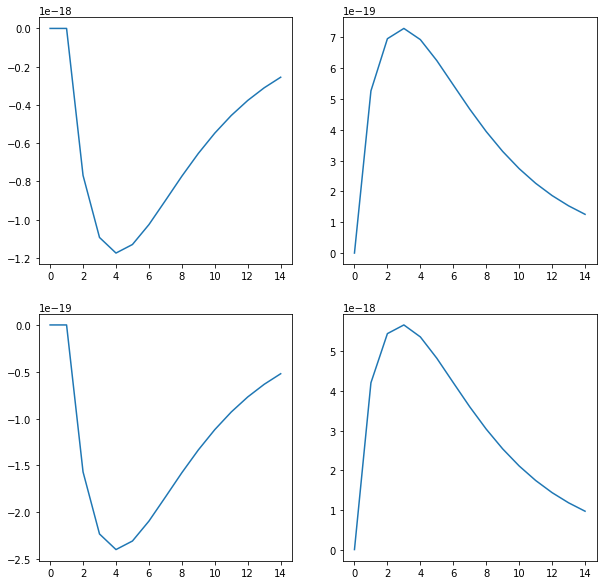

In [48]:
fig,ax=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
ax[0,0].plot(t,y_t[:,0])
ax[0,1].plot(t,y_t[:,1])
ax[1,0].plot(t,y_t[:,2])
ax[1,1].plot(t,y_t[:,3])
fig.show()